In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os

import PlaceCellAnalysis as pc
import utilities as u
import preprocessing as pp
import behavior as b
import BayesianDecoding as bd


%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
mice = ['4139190.1','4139190.3','4139212.2','4139219.2','4139219.3','4139224.2','4139224.3','4139224.5']
df = pp.load_session_db()
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])

In [3]:
mouse = '4139224.3'

In [4]:
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse = df_mouse[df_mouse['Track'].str.match('TwoTower_noTimeout') | df_mouse['Track'].str.match('TwoTower_Timeout')]

sess = df_mouse.iloc[8]
VRDat,C,Cd, S, A = pp.load_scan_sess(sess)
trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
S_trial_mat, occ, edges, centers = u.make_pos_bin_trial_matrices(S,VRDat.pos._values,tstart_inds,teleport_inds)
C_trial_mat, occ, edges, centers = u.make_pos_bin_trial_matrices(C,VRDat.pos._values,tstart_inds,teleport_inds)


G:\My Drive\2P_Data\TwoTower\4139224.3\30_10_2018\TwoTower_Timeout\TwoTower_Timeout_001_002.mat


C:\Users\mplitt\MightyMorphingPhotonRangers\preprocessing.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  frame['ca inds'] = caInds
C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


G:\My Drive\2P_Data\TwoTower\4139224.3\30_10_2018\TwoTower_Timeout\TwoTower_Timeout_001_002.mat
#subsystem#not made into numpy array
Anot made into numpy array
frame diff 0


C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:251: RuntimeWarning: Mean of empty slice
  zone1_speed[i] = np.nanmean(sub_frame.loc[zone1_mask,'speed'])


In [5]:
C_dict = u.trial_type_dict(C_trial_mat,trial_info['morphs'])


G:\My Drive\2P_Data\TwoTower\4139224.3\30_10_2018\TwoTower_Timeout\TwoTower_Timeout_001_002.mat


C:\Users\mplitt\MightyMorphingPhotonRangers\preprocessing.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  frame['ca inds'] = caInds
C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


G:\My Drive\2P_Data\TwoTower\4139224.3\30_10_2018\TwoTower_Timeout\TwoTower_Timeout_001_002.mat
#subsystem#not made into numpy array
Anot made into numpy array
frame diff 0


C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:251: RuntimeWarning: Mean of empty slice
  zone1_speed[i] = np.nanmean(sub_frame.loc[zone1_mask,'speed'])


[0.00203471 0.00094563 0.00063808 ... 0.00086654 0.00074114 0.00168139]
[0.00118542 0.00104928 0.00184224 ... 0.00147274 0.00172109 0.00064372]
morph 0 place cells = 566 out of 1027 , 0.551120 
morph 1 place cells = 479 out of 1027, 0.466407
common place cells = 255


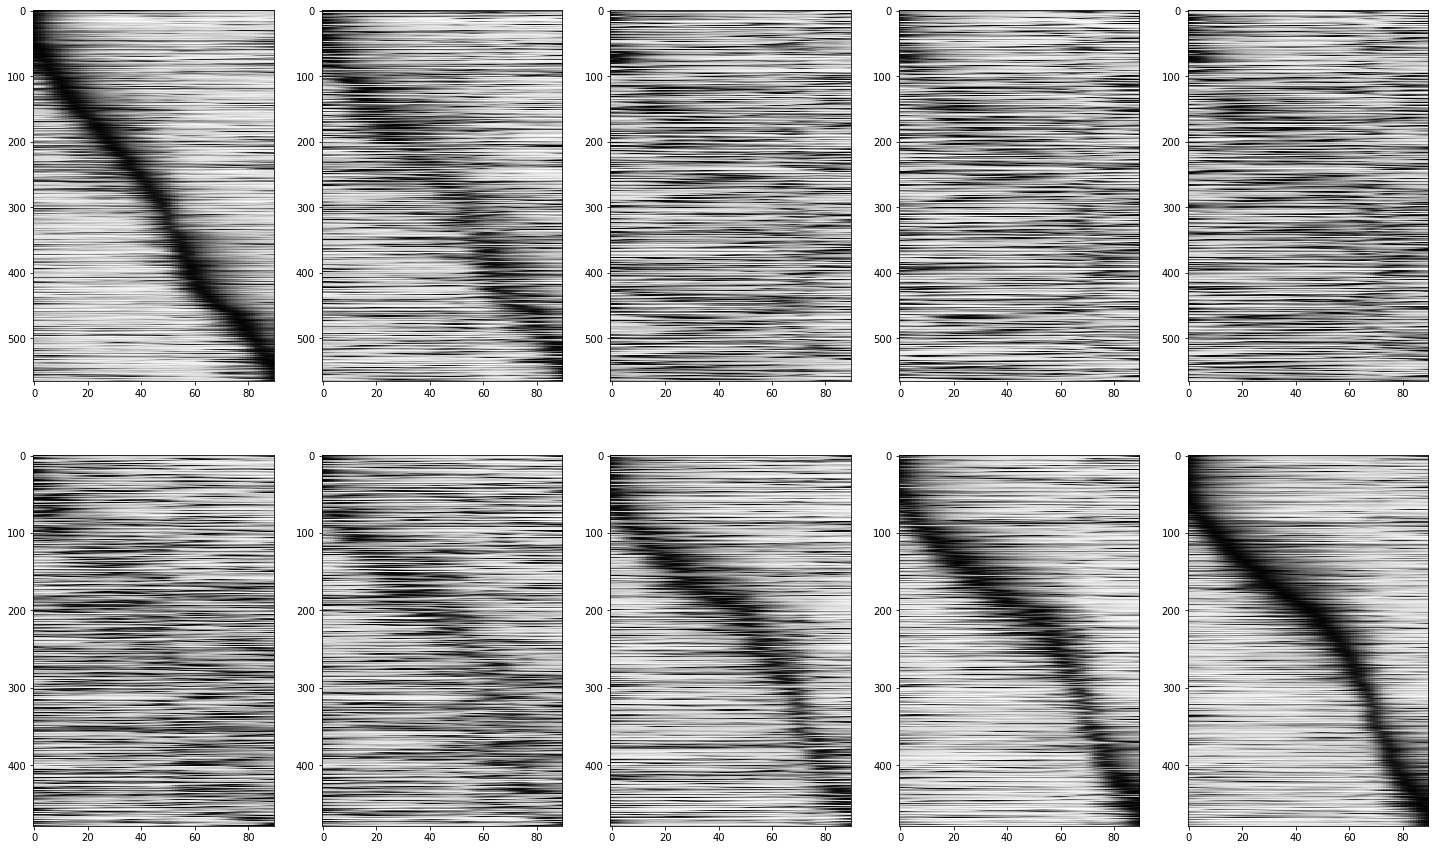

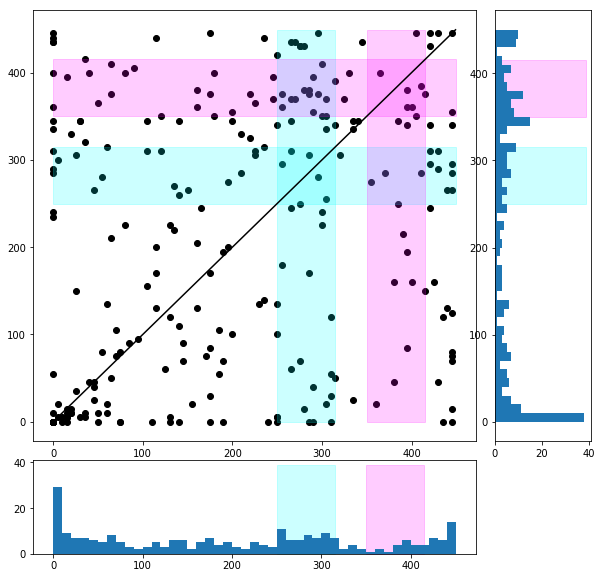

In [73]:
######### population vector correlation

# calculate place cells
FR,masks,SI = pc.single_session(sess)


In [74]:
# get cells that have place field in two extremes
common_pc = np.multiply(masks[0],masks[1])
FR_dict = {k:np.nanmean(v[:,:,common_pc],axis=0) for k,v in C_dict.items() if k not in ('all','labels','indices')}
remapMask = np.zeros([common_pc.sum(),])
thr = 50
for c in range(common_pc.sum()):
    shift = np.abs(np.argmax(FR_dict[0][:,c])-np.argmax(FR_dict[1][:,c]))*5.
    if shift>thr:
        remapMask[c]=1
    
remapMask = remapMask>0
#common_pc = (masks[0]+masks[1])>0
FRrm_dict = {k:v[:,remapMask] for k,v in FR_dict.items()}

In [75]:
FR_dict = {k:np.nanmean(v[:,:,common_pc],axis=0) for k,v in C_dict.items() if k not in ('all','labels','indices')}

In [76]:
print(FR_dict[0].shape)

(90, 255)


In [77]:
FRCorrs = np.zeros([5,5,remapMask.sum()])
for i,(k,v) in enumerate(FRrm_dict.items()):
    for j,(kk,vv) in enumerate(FRrm_dict.items()):
        for n in range(remapMask.sum()):
            
#             FRCorrs[i,j,n],p = sp.stats.pearsonr(v[:,n].ravel(),vv[:,n].ravel())
            FRCorrs[i,j,n] = sp.spatial.distance.cosine(v[:,n].ravel(),vv[:,n].ravel())
            

for i in range(5):
    for n in range(remapMask.sum()):
        rng = FRCorrs[i,:,n].max()-FRCorrs[i,:,n].min()
        FRCorrs[i,:,n]/=rng

In [78]:
print(FRCorrs[4,:,100])

[1.         0.72214275 0.64829152 0.08342865 0.        ]


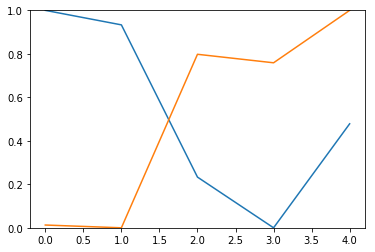

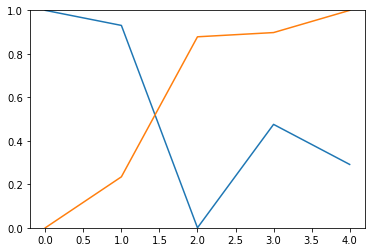

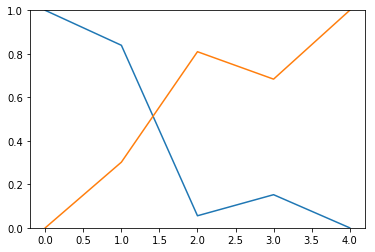

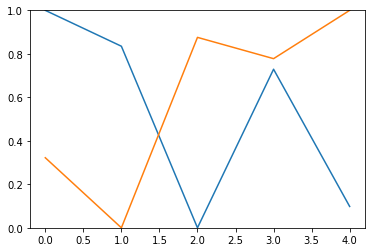

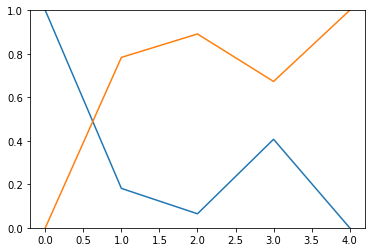

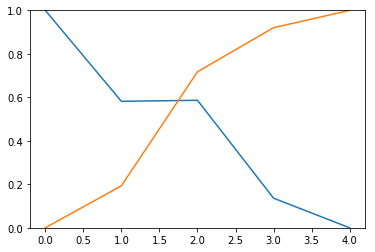

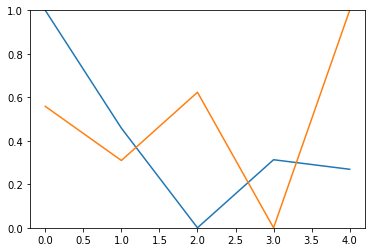

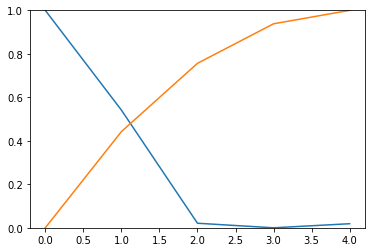

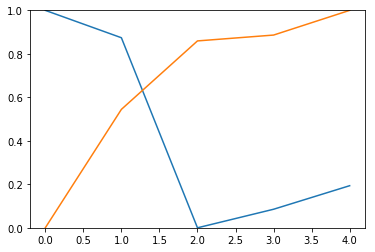

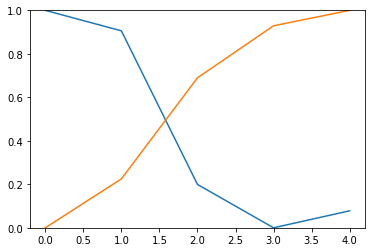

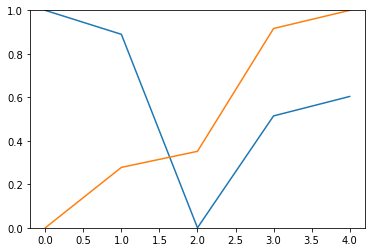

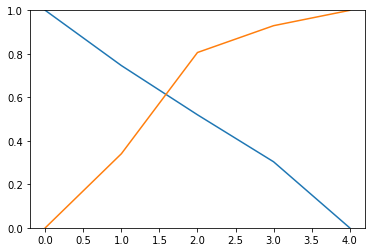

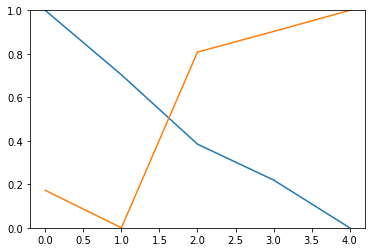

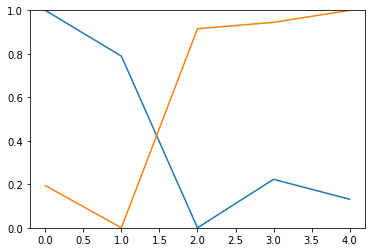

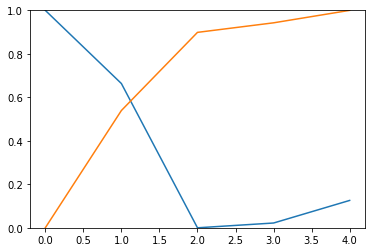

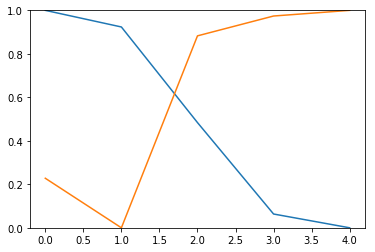

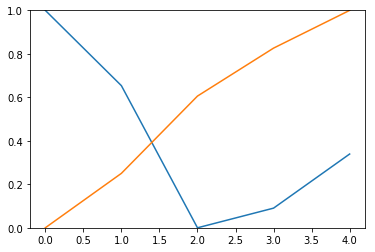

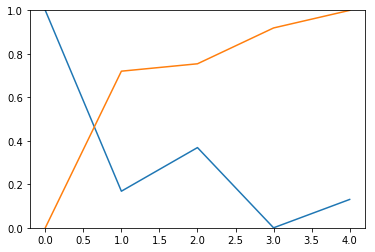

In [79]:

for n in range(0,remapMask.sum(),10):
    f,ax = plt.subplots()
    ax.plot(1-FRCorrs[0,:,n])
    ax.plot(1-FRCorrs[-1,:,n])
    ax.set_ylim([0,1])

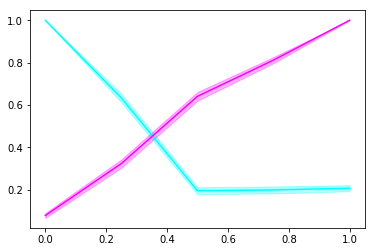

In [80]:
popmu=FRCorrs.mean(axis=-1)
popsem = sp.stats.sem(FRCorrs,axis=-1)
f, ax = plt.subplots()
m = [0.,.25,.5,.75,1]
ax.plot(m,1-popmu[0,:],color=plt.cm.cool(0.))
ax.plot(m,1-popmu[-1,:],color=plt.cm.cool(1.))
ax.fill_between(m,1-popmu[0,:]+popsem[0,:],y2=1-popmu[0,:]-popsem[0,:],color=plt.cm.cool(0.),alpha=.3)
ax.fill_between(m,1-popmu[-1,:]+popsem[-1,:],y2=1-popmu[-1,:]-popsem[-1,:],color=plt.cm.cool(1.),alpha=.3)

C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:251: RuntimeWarning: Mean of empty slice
  zone1_speed[i] = np.nanmean(sub_frame.loc[zone1_mask,'speed'])


((<Figure size 360x360 with 1 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x25e21c8d5f8>),
 (<Figure size 360x360 with 1 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x25e2199e198>),
 (<Figure size 360x360 with 1 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x25e569a4be0>))

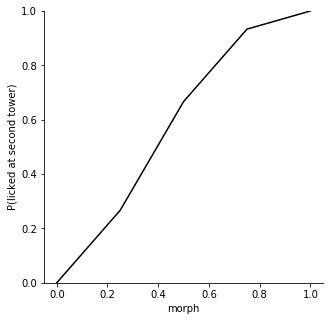

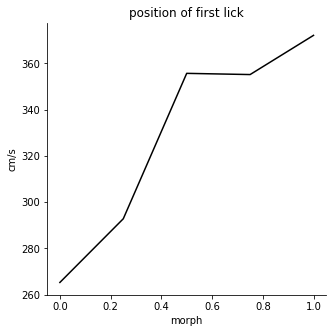

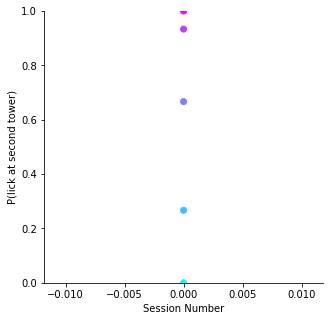

In [71]:
b.learning_curve_plots([VRDat])